In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dataset-small:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5242496%2F8733624%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T013200Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d0464ea1ed2fa0124d96dd82823d933ddade4fbe65d59343d3592b5c2dd1fe1ba9bbaa4f113ce3fbec70fa374b62f8803ebdc112feb1d86731dff0073260690f8aeaf389e7bf5c04699416bf9be53a7042b4f5d8ff94580d238cb4749244d83a15dd3dd36f17ead8dedc957e82bb8d5dee001e2569433fbfc7e3394a43dd9f1260be12f772547e602c5454e97b7aebfbb9d00751377a2c190348c0a57863c32c9f18e5fef88d36f27c09d970bd2a0708bd753fe257dce31b4977d98fc61075b0a93526731105aa4d34c9ce1804636c8b31cb624f0e8167f73551ab05c97c989a1a220b97db51b085e313e3d386fade2e5aa97f950fe489d05a525d1ae115bf9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 10695 bytes downloaded
Downloaded and uncompressed: dataset-small
Data source import complete.


In [ ]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding,SimpleRNN,GRU
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from string import punctuation
punct = list(punctuation)
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data=pd.read_csv("/kaggle/input/dataset-small/dataset_small.csv")
data.shape

(199, 3)

In [ ]:
# Renaming columns
data = data.rename(columns={'Label':'Rating'})
data = data.rename(columns={'CourseId':'CourseName'})
data.head()

,CourseName,Review,Rating
0,2-speed-it,I was disappointed because the name is mislead...,3
1,2-speed-it,Videos that are presented in French could've b...,4
2,2-speed-it,"Excellent course, for me it was very rewarding...",5
3,2-speed-it,Super content. I'll definitely re-do the course,5
4,2-speed-it,Etant contrÃ´leur de gestion pour le dÃ©partem...,5


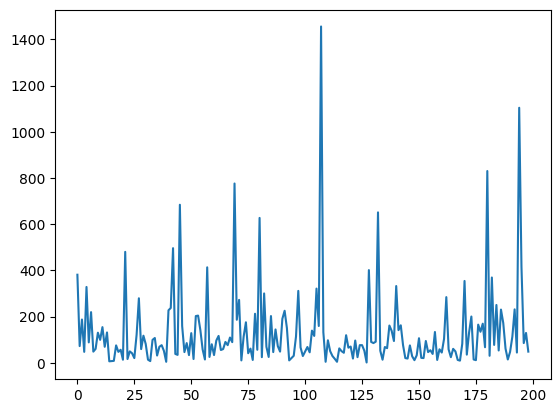

In [ ]:
# Plotting word lenghts of reviews
data['Review'] = data['Review'].astype(str)
word_length = [len(x) for x in data['Review']]
plt.plot(word_length)

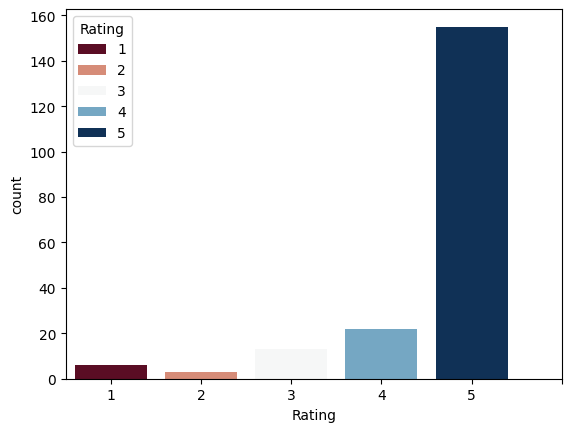

In [ ]:
sns.countplot(x=data['Rating'], data=data, hue=data['Rating'], palette='RdBu', dodge=False)
plt.xticks([0,1,2,3,4,5])
plt.show()

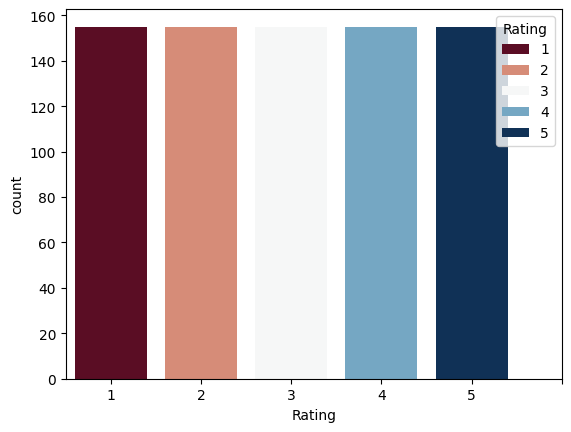

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='all')
# fit and apply the transform
#X = data.drop(columns=['Rating','CourseName'])
X = data[['Review']]
y = data['Rating']
X_over, y_over = oversample.fit_resample(X, y)
sns.countplot(x=y_over, data=data, hue=y_over, palette='RdBu', dodge=False)
plt.xticks([0,1,2,3,4,5])
plt.show()

In [ ]:
#Combining oversampled columns to create dataframe
data_over = pd.concat([X_over, y_over], axis=1)

In [ ]:
data_over.head()

,Review,Rating
0,I was disappointed because the name is mislead...,3
1,Videos that are presented in French could've b...,4
2,"Excellent course, for me it was very rewarding...",5
3,Super content. I'll definitely re-do the course,5
4,Etant contrÃ´leur de gestion pour le dÃ©partem...,5


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def predict_sentiment(sequence):
  # Apply tokenization on our input sentence
  inputs = tokenizer(sequence, return_tensors='pt')
  # Do the prediction and save the logits
  logits = model(**inputs).logits
  # Find the class (Positive, Neutral, or Negative) which has the highest probability
  predicted_class_id = logits.argmax().item()
  # Return the predicted class
  return(model.config.id2label[predicted_class_id])

# Call predict_sentiment for all sentences
data_over['Sentiment'] = data_over['Review'].apply(lambda Review: predict_sentiment(Review))
# The lambda function used here is a Pythonic approach to write an anonymous function
# and it can take any number of arguments.

In [ ]:
data_over.head(10)

,Review,Rating,Sentiment
0,I was disappointed because the name is mislead...,3,NEGATIVE
1,Videos that are presented in French could've b...,4,NEGATIVE
2,"Excellent course, for me it was very rewarding...",5,POSITIVE
3,Super content. I'll definitely re-do the course,5,POSITIVE
4,Etant contrÃ´leur de gestion pour le dÃ©partem...,5,POSITIVE
5,One of the excellent courses at Coursera for i...,5,POSITIVE
6,Is there any reason why you should not apply t...,5,POSITIVE
7,Excellent course and teachers. Congratulations!!,5,POSITIVE
8,This is a good course for an CIO in a non tech...,5,POSITIVE
9,"Good content, but the course setting does (at ...",3,NEGATIVE


In [ ]:
data_over['review_sentiment']=data_over['Sentiment'].apply(lambda x: 1 if x=='POSITIVE' else 0)
data_over.head()

,Review,Rating,Sentiment,review_sentiment
0,I was disappointed because the name is mislead...,3,NEGATIVE,0
1,Videos that are presented in French could've b...,4,NEGATIVE,0
2,"Excellent course, for me it was very rewarding...",5,POSITIVE,1
3,Super content. I'll definitely re-do the course,5,POSITIVE,1
4,Etant contrÃ´leur de gestion pour le dÃ©partem...,5,POSITIVE,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_over['Review'],data_over['review_sentiment'], test_size=0.2)

In [ ]:
pip install -U "tensorflow-text==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.4 MB/s eta 0:00:00


In [ ]:
#pip install tensorflow-hub
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#text_input = tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


In [ ]:
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
20/20 [==============================] - 3s 161ms/step - loss: 0.3405 - accuracy: 0.8823 - precision: 0.8645 - recall: 0.8676
Epoch 2/30
20/20 [==============================] - 3s 160ms/step - loss: 0.3289 - accuracy: 0.8710 - precision: 0.8556 - recall: 0.8493
Epoch 3/30
20/20 [==============================] - 3s 159ms/step - loss: 0.3315 - accuracy: 0.8806 - precision: 0.8613 - recall: 0.8676
Epoch 4/30
20/20 [==============================] - 3s 160ms/step - loss: 0.3366 - accuracy: 0.8677 - precision: 0.8519 - recall: 0.8456
Epoch 5/30
20/20 [==============================] - 3s 160ms/step - loss: 0.3138 - accuracy: 0.8710 - precision: 0.8664 - recall: 0.8346
Epoch 6/30
20/20 [==============================] - 3s 159ms/step - loss: 0.3154 - accuracy: 0.8871 - precision: 0.8713 - recall: 0.8713
Epoch 7/30
20/20 [==============================] - 3s 159ms/step - loss: 0.3092 - accuracy: 0.8887 - precision: 0.8612 - recall: 0.8897
Epoch 8/30
20/20 [=======================

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 2s 161ms/step - loss: 0.2660 - accuracy: 0.8839 - precision: 0.9647 - recall: 0.8454


[0.2660215198993683,
 0.8838709592819214,
 0.9647058844566345,
 0.8453608155250549]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

5/5 [==============================] - 2s 159ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0])

Text(50.722222222222214, 0.5, 'Truth')

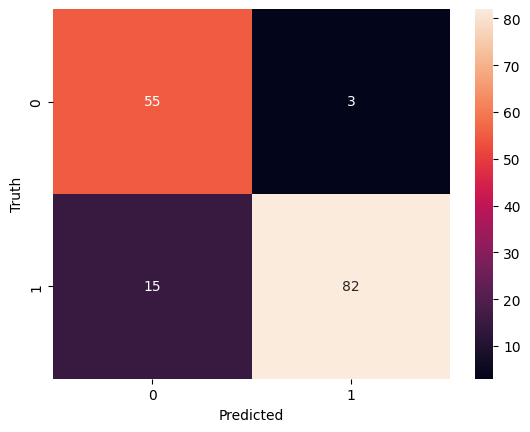

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86        58
           1       0.96      0.85      0.90        97

    accuracy                           0.88       155
   macro avg       0.88      0.90      0.88       155
weighted avg       0.90      0.88      0.89       155

